# This notebook uses the following vital sign to predict 15-day survival in ICU for TBI patient:
- first four hour mean CPP
- first four hour mean ICP
- GCS (eye, mobility). GCS verbal is not included as many patient are on ventilator
- age, and sex

#### Reference: Machine learning-based dynamic mortality prediction after traumatic brain injury
#### Nature Article: https://www.nature.com/articles/s41598-019-53889-6

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import psycopg2
import getpass

import os

# Create a database connection
# Credentials saved on local environment 
# in HOME directory, use vim .bash_profile to edit

dbuser = os.environ.get('dbuser')
dbhost = os.environ.get('dbhost')
dbname = os.environ.get('dbname')
dbschema = os.environ.get('dbschema')
dbpwd = os.environ.get('dbpwd')
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, 
                       password=dbpwd)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(dbschema))


# CDC definition of TBI on ICD codes
The CDC’s case definition22 defines TBI visits as visits
with one of the following International Classification
of Diseases, Ninth Revision (ICD-9), Clinical Modification
(ICD-9-CM), diagnosis codes: fracture of the vault or
base of the skull (801.0-801.9); other and unqualified
multiple fractures of the skull (803.0-804.9); intracranial
injury including concussion, contusion, laceration, and
hemorrhage (85-854.1); injury to the optic nerve and
pathways (951-953); shaken baby syndrome (995.55);
and head injury unspecified (959.01).

In [2]:
#prepare data frame
query_TBI_ML = \
"""
/*query all the data including vitals chart events*/
SELECT  
		ad.hadm_id,
        pa.gender,
		(DATE_PART('year', ad.admittime::date) - DATE_PART('year', pa.dob::date)) AS age,
		ad.admittime,
		(	(DATE_PART('day', ad.deathtime::timestamp - ad.admittime::timestamp))*24 +
			(DATE_PART('hour', ad.deathtime::timestamp - ad.admittime::timestamp))) AS hrstodeath,
		gcs.gcseyes,
		gcs.gcsmotor,
        gcs.gcsverbal,
		ce.charttime,
		di.label,
		ce.valuenum,
/*        ne.description,*/
		ad.hospital_expire_flag   
FROM mimiciii.admissions AS ad
INNER JOIN mimiciii.icustays AS icu ON ad.hadm_id = icu.hadm_id
INNER JOIN mimiciii.pivoted_gcs AS gcs ON icu.icustay_id = gcs.icustay_id
INNER JOIN mimiciii.chartevents AS ce ON ce.hadm_id = ad.hadm_id
INNER JOIN mimiciii.d_items as di ON ce.itemid = di.itemid
/*INNER JOIN mimiciii.noteevents AS ne ON ne.hadm_id = ad.hadm_id*/
INNER JOIN mimiciii.diagnoses_icd AS d ON d.hadm_id = ad.hadm_id
INNER JOIN mimiciii.patients AS pa ON pa.subject_id = ad.subject_id
WHERE 	
		(
			di.label like ('CPP')
		 OR
			di.label like ('ICP')
		) 
		AND
		(
			(d.icd9_code >= '8010' AND d.icd9_code < '8019')
		OR 
			(d.icd9_code >= '8030' AND d.icd9_code < '8049')
		OR
			(d.icd9_code >= '85' AND d.icd9_code < '8541')
		OR
			(d.icd9_code >= '951' AND d.icd9_code < '953')
		OR
			d.icd9_code IN ('95555', '95901')
		)
/*		AND
		ad.hospital_expire_flag = 1 */


 
"""
data_TBI_ML = pd.read_sql_query(query_TBI_ML,con)
#data_TBI = pd.DataFrame(data_TBI)
#data_TBI.fillna({'label':'Other', 'flag':'normal'}, inplace=True)
#data_TBI_ML.drop_duplicates(inplace = True)
#remove negative delay rows
#data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.chartdelayhrs <0].index, inplace=True)
#remove hadm_id
#data_TBI_ML.drop(['hadm_id'], axis=1, inplace=True)

data_TBI_ML.to_csv("TBI_ML.csv", index=False)

In [3]:
data_TBI_ML.hadm_id.nunique()

153

In [4]:
data_TBI_ML.describe()

,hadm_id,age,hrstodeath,gcseyes,gcsmotor,gcsverbal,valuenum,hospital_expire_flag
count,8.893873e+06,8.893873e+06,940629.000000,8.883172e+06,8.873961e+06,8.881266e+06,8.793045e+06,8.893873e+06
mean,1.521715e+05,4.173587e+01,237.866003,2.249216e+00,4.038048e+00,4.099008e-01,4.540428e+01,1.057615e-01
std,3.122604e+04,2.038773e+01,86.426586,1.309085e+00,1.741768e+00,1.225579e+00,3.305406e+01,3.075321e-01
min,1.007640e+05,1.600000e+01,3.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.190030e+05,2.300000e+01,168.000000,1.000000e+00,4.000000e+00,0.000000e+00,1.300000e+01,0.000000e+00
50%,1.490040e+05,3.800000e+01,275.000000,2.000000e+00,4.000000e+00,0.000000e+00,3.800000e+01,0.000000e+00
75%,1.807250e+05,5.900000e+01,286.000000,4.000000e+00,5.000000e+00,0.000000e+00,7.500000e+01,0.000000e+00
max,1.999760e+05,8.900000e+01,372.000000,4.000000e+00,6.000000e+00,5.000000e+00,2.000000e+02,1.000000e+00


In [5]:
import numpy as np
from datetime import datetime
dtypes={"gender": str, "age": np.int64, "hadm_id":str, "admittime": str, 
        "hrstodeath":np.float, "charttime": str, 
      "label":str, "valuenum":np.float, "hospital_expire_flag":int, 
        "gcseyes":np.float,"gcsmotor":np.float, "gcsverbal":np.float}

data_TBI_ML = pd.read_csv("TBI_ML.csv", dtype = dtypes)#,parse_dates=[4,5,9], infer_datetime_format=True)



In [6]:
#data_TBI_ML.reset_index(inplace=True)
#data_TBI_ML.drop(['icd9_code','deathtime'], axis = 1, inplace=True)
data_TBI_ML['charttimedelay'] = pd.to_datetime(data_TBI_ML['charttime']) - pd.to_datetime(data_TBI_ML['admittime'])
# data_TBI_ML.drop('admittime', axis = 1, inplace=True)
# data_TBI_ML.drop('charttime', axis = 1, inplace=True)

data_TBI_ML['charttimedelay'] = data_TBI_ML['charttimedelay'].apply(lambda x: x/ np.timedelta64(1,'h')).astype('int64')
data_TBI_ML.hrstodeath.fillna(0, inplace = True)
data_TBI_ML.head()

,hadm_id,gender,age,admittime,hrstodeath,gcseyes,gcsmotor,gcsverbal,charttime,label,valuenum,hospital_expire_flag,charttimedelay
0,183430,M,79,2170-06-12 03:27:00,0.0,3.0,5.0,0.0,2170-06-14 08:00:00,ICP,17.0,0,52
1,183430,M,79,2170-06-12 03:27:00,0.0,3.0,5.0,0.0,2170-06-14 08:00:00,ICP,17.0,0,52
2,183430,M,79,2170-06-12 03:27:00,0.0,3.0,5.0,0.0,2170-06-14 08:00:00,ICP,17.0,0,52
3,183430,M,79,2170-06-12 03:27:00,0.0,3.0,5.0,0.0,2170-06-14 08:00:00,ICP,17.0,0,52
4,183430,M,79,2170-06-12 03:27:00,0.0,3.0,5.0,0.0,2170-06-14 08:00:00,ICP,17.0,0,52


# Aggregate vital sign data into 4 hours bucket for training

In [7]:
# df1 = data_TBI_ML.groupby(['hadm_id','gender', 'age','hrstodeath', 'hospital_expire_flag', 'gcseyes','gcsmotor',
#                            'label']).aggregate({'valuenum':'mean'})
#average of first 4 hours
data_TBI_ML['charttimedelay'] = data_TBI_ML['charttimedelay'].map(lambda x: int(x / 4)) 
df1 = data_TBI_ML.groupby(['hadm_id', 'gender','age','hrstodeath', 'hospital_expire_flag', 
                           'label','charttimedelay']).aggregate({'valuenum':'mean', 
                                                                 'gcseyes':'mean', 
                                                                 'gcsmotor':'mean',
                                                                'gcsverbal':'mean'})


#df1.reset_index(inplace = True)
df1

valuenum  \
hadm_id gender age hrstodeath hospital_expire_flag label charttimedelay              
100764  M      57  0.0        0                    CPP   0               73.000000   
                                                         1               74.333333   
                                                         2               72.100000   
                                                         3               71.166667   
                                                         4               68.285714   
...                                                                            ...   
199976  M      77  0.0        0                    ICP   13              17.000000   
                                                         14              12.600000   
                                                         15              17.250000   
                                                         16              18.500000   
                                                         19                    NaN   

                                                                          gcseyes  \
hadm_id gender age hrstodeath hospital_expire_flag label charttimedelay             
100764  M      57  0.0        0                    CPP   0               2.743902   
                                                         1               2.743902   
                                                         2               2.743902   
                                                         3               2.743902   
                                                         4               2.743902   
...                                                                           ...   
199976  M      77  0.0        0                    ICP   13              2.954098   
                                                         14              2.954098   
                                                         15              2.954098   
                                                         16              2.954098   
                                                         19              2.954098   

                                                                         gcsmotor  \
hadm_id gender age hrstodeath hospital_expire_flag label charttimedelay             
100764  M      57  0.0        0                    CPP   0               5.317073   
                                                         1               5.317073   
                                                         2               5.317073   
                                                         3               5.317073   
                                                         4               5.317073   
...                                                                           ...   
199976  M      77  0.0        0                    ICP   13              5.147541   
                                                         14              5.147541   
                                                         15              5.147541   
                                                         16              5.147541   
                                                         19              5.147541   

                                                                         gcsverbal  
hadm_id gender age hrstodeath hospital_expire_flag label charttimedelay             
100764  M      57  0.0        0                    CPP   0                0.536585  
                                                         1                0.536585  
                                                         2                0.536585  
                                                         3                0.536585  
                                                         4                0.536585  
...                                                                            ...  
199976  M      77  0.0        0                    ICP   13    

In [8]:
df2 = df1.unstack('label')

df2.columns = df2.columns.get_level_values(0)
df2.columns = ['CPP', 'ICP', 'gcseyes', 'gcseyes2', 'gcsmotor', 'gcsmotor2', 'gcsverbal', 'gcsverbal2']

df2 = df2.drop(['gcseyes2', 'gcsmotor2','gcsverbal2'],1)
df2.reset_index(inplace = True)
df2['mort15'] = np.where((df2['hospital_expire_flag']==1) & (df2['hrstodeath'] < 15*24), 1, 0)
df2.describe()

,age,hrstodeath,hospital_expire_flag,charttimedelay,CPP,ICP,gcseyes,gcsmotor,gcsverbal,mort15
count,4995.000000,4995.000000,4995.000000,4995.000000,4618.000000,4910.000000,4700.000000,4700.000000,4700.000000,4995.000000
mean,42.357958,43.218218,0.222422,38.000200,75.143250,15.830140,2.110358,3.843053,0.394533,0.220621
std,20.707181,94.476284,0.415915,34.512745,13.194271,10.603423,0.768444,1.307380,0.724504,0.414707
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,11.000000,67.557292,9.635417,1.488263,3.134146,0.010695,0.000000
50%,39.000000,0.000000,0.000000,27.000000,75.000000,13.500000,2.152263,3.818713,0.053846,0.000000
75%,62.000000,0.000000,0.000000,57.000000,82.750000,19.000000,2.686957,4.913043,0.596330,0.000000
max,89.000000,372.000000,1.000000,188.000000,127.400000,104.333333,3.803150,6.000000,4.559055,1.000000


In [9]:
df3 = df2.loc[df2['charttimedelay'] == 0]
df3 = df3.drop(['hadm_id', 'hrstodeath', 'hospital_expire_flag', 'charttimedelay','gcsverbal'],1)
df3.fillna(method = 'ffill', inplace = True)

df3['gender'].replace('F', 0, inplace=True)
df3['gender'].replace('M', 1, inplace=True)
df3

,gender,age,CPP,ICP,gcseyes,gcsmotor,mort15
0,1,57,73.000000,15.500000,2.743902,5.317073,0
93,1,66,64.600000,6.800000,1.000000,1.157895,1
122,0,43,71.000000,3.500000,3.690789,5.625000,0
126,1,18,90.800000,6.400000,1.000000,2.629630,1
131,0,54,50.200000,24.000000,3.347222,4.845070,0
...,...,...,...,...,...,...,...
4617,0,36,84.666667,11.333333,2.293194,4.726316,0
4693,1,58,67.600000,7.166667,1.600000,3.800000,1
4715,1,33,58.500000,23.000000,2.780952,5.884615,0
4746,1,30,69.250000,54.750000,1.000000,1.000000,1


In [10]:
# from sklearn.model_selection import cross_val_score
# from sklearn import svm

# X=df3.copy()
# y = X['mort15']
# X.drop(['mort15'], axis=1, inplace=True)

# clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(clf, X, y, cv=5)

# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [11]:
# from sklearn import datasets
# from sklearn.model_selection import cross_val_predict
# from sklearn import linear_model
# import matplotlib.pyplot as plt

# #lr = linear_model.LinearRegression()
# model = RandomForestClassifier(n_estimators=200, random_state=0)
# # cross_val_predict returns an array of the same size as `y` where each entry
# # is a prediction obtained by cross validation:
# scores = cross_val_score(model, X, y, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# #predicted = cross_val_predict(model, X, y, cv=10)



# Training

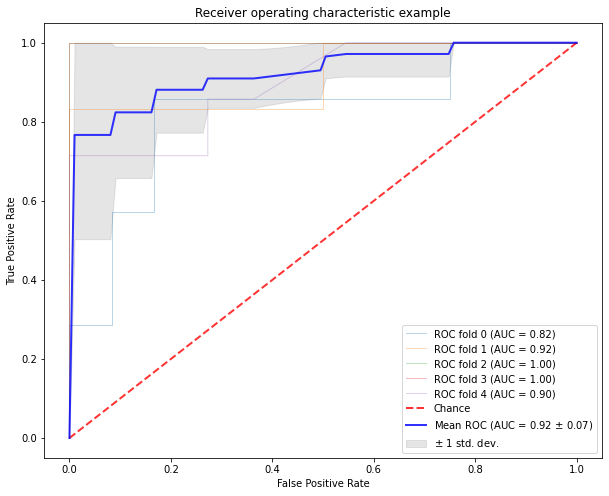

In [12]:

# from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# #############################################################################
# Data IO and generation

# Import some data to play with
X=df3.copy()
X.reset_index(inplace = True)
y = X['mort15']
X.drop(['mort15'], axis=1, inplace=True)


n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(n_estimators=300,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [13]:
mean_auc

0.9228956228956229

In [14]:
n_samples

91